<a href="https://colab.research.google.com/github/AnabelleSouza/CRUD_PDO-CONTEINER/blob/main/wine_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exercício 2


In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [ ]:
import pandas as pd
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pymc as pm
import numpy as np
import arviz as az



In [ ]:
# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separar dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az


def analise_priori(trace, y):
    fig, axes = plt.subplots(3, 2, figsize=(10, 10), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

    # Acessar os valores dos betas a partir do grupo 'prior'
    betas_values = trace.prior['betas'].values.flatten()  # Acessa os betas do grupo 'prior' e achata
    sns.histplot(betas_values, bins=20, kde=True, ax=axes[0][0])
    axes[0][0].set_xlabel("Betas")
    axes[0][0].set_ylabel("Contagem")

    # Histograma para as previsões da variável dependente (priors)
    y_obs_values = trace.prior_predictive['Y_obs'].values.flatten()  # Acessa as previsões a priori de Y_obs
    sns.histplot(y_obs_values, bins=20, kde=True, ax=axes[0][1])
    axes[0][1].set_xlabel("Previsões a Priori (Y_obs)")
    axes[0][1].set_ylabel("Contagem")

    # Previsões a priori
    prior_samples = trace.prior_predictive['Y_obs'].values  # Acessa os valores de Y_obs a partir da distribuição preditiva
    prior_samples_reshaped = prior_samples.reshape(len(y), -1)

    # Cálculo da média e desvio padrão das previsões a priori
    mean_pred = np.mean(prior_samples_reshaped, axis=1)
    std_pred = np.std(prior_samples_reshaped, axis=1)

    # Plotar as previsões médias a priori
    sns.lineplot(x=range(len(y)), y=mean_pred, ax=axes[1][0])
    axes[1][0].fill_between(range(len(y)), mean_pred - std_pred, mean_pred + std_pred, alpha=0.2)

    axes[1][0].set_title("Previsões a Priori")
    axes[1][0].set_xlabel("Observado")
    axes[1][0].set_ylabel("Previsões")
    axes[1][0].legend(['Previsões Médias'])

    # Gráficos cumulativos da priori usando Arviz
    az.plot_ppc(trace, group='prior', kind='cumulative', ax=axes[2][0], observed=True)
    az.plot_ppc(trace, group='prior', ax=axes[2][1], observed=True)

    plt.tight_layout()
    return fig, axes

RIDGE

In [ ]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Certificar que y tenha a forma correta
y = y.reshape(-1)  # Garante que y seja um vetor unidimensional

# Definir as coordenadas do modelo (quantidade de features)
coords = {'features': np.arange(X_scaled.shape[1])}

# Criar o modelo Ridge Bayesiano
with pm.Model(coords=coords) as model_ridge:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Priori para os coeficientes de regressão (betas)
    betas = pm.Normal('betas', mu=0, sigma=10, dims='features')

    # Priori para o desvio padrão do erro (epsilon)
    epsilon = pm.Gamma('epsilon', alpha=2, beta=1)  # Gamma prior para epsilon

    # Definir a equação do modelo linear
    mu = alpha + pt.dot(X_scaled, betas)  # Substituir tt.dot por pt.dot

    # Definir a verossimilhança (Normal)
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=y)

    # Amostrar da distribuição a priori (para análise a priori)
    ridge_trace_prior = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior (para ajuste do modelo)
    trace_ridge = pm.sample(1000, tune=1000, target_accept=0.95)

# Exibir o resumo dos parâmetros ajustados

az.summary(trace_ridge)

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.818,0.009,5.802,5.834,0.000,0.000,1863.0,1430.0,1.0
betas[0],0.088,0.020,0.049,0.125,0.001,0.000,939.0,1249.0,1.0
betas[1],-0.219,0.013,-0.242,-0.195,0.000,0.000,1615.0,1580.0,1.0
betas[2],-0.016,0.011,-0.039,0.004,0.000,0.000,1658.0,1395.0,1.0
betas[3],0.208,0.025,0.164,0.257,0.001,0.001,941.0,1165.0,1.0
betas[4],-0.017,0.011,-0.039,0.004,0.000,0.000,2048.0,1525.0,1.0
betas[5],0.106,0.013,0.083,0.132,0.000,0.000,1782.0,1399.0,1.0
betas[6],-0.141,0.015,-0.168,-0.111,0.000,0.000,1283.0,1524.0,1.0
betas[7],-0.165,0.037,-0.234,-0.098,0.001,0.001,775.0,1076.0,1.0
betas[8],0.070,0.014,0.042,0.094,0.000,0.000,999.0,1317.0,1.0


In [ ]:
# Amostrar da distribuição posterior preditiva
posterior_predictive = pm.sample_posterior_predictive(trace_ridge, model=model_ridge)

 # Imprimir as chaves do posterior_predictive
print(posterior_predictive.keys())


Output()

KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)


In [ ]:
# Verificar as chaves do posterior_predictive
print(posterior_predictive['posterior_predictive'].keys())

# Verificar as chaves do observed_data
print(posterior_predictive['observed_data'].keys())

KeysView(<xarray.Dataset> Size: 104MB
Dimensions:      (chain: 2, draw: 1000, Y_obs_dim_2: 6497)
Coordinates:
  * chain        (chain) int64 16B 0 1
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 52kB 0 1 2 3 4 ... 6492 6493 6494 6495 6496
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 104MB 5.326 5.369 ... 4.559
Attributes:
    created_at:                 2024-09-24T12:03:13.839905+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2)
KeysView(<xarray.Dataset> Size: 104kB
Dimensions:      (Y_obs_dim_0: 6497)
Coordinates:
  * Y_obs_dim_0  (Y_obs_dim_0) int64 52kB 0 1 2 3 4 ... 6492 6493 6494 6495 6496
Data variables:
    Y_obs        (Y_obs_dim_0) float64 52kB 5.0 5.0 5.0 6.0 ... 5.0 6.0 7.0 6.0
Attributes:
    created_at:                 2024-09-24T12:03:13.843459+00:00
    arviz_version:              0.19.0
    inference_librar

In [ ]:
# Acessar dados preditivos de Y_obs
y_obs_pred = posterior_predictive['posterior_predictive']['Y_obs']
print(y_obs_pred)

# Cálculo da média ou outras estatísticas
y_obs_mean = y_obs_pred.mean(axis=0)
print(y_obs_mean)


<xarray.DataArray 'Y_obs' (chain: 2, draw: 1000, Y_obs_dim_2: 6497)> Size: 104MB
array([[[5.32639839, 5.36864906, 4.7279203 , ..., 6.99615224,
         5.16293407, 6.05206946],
        [4.50526667, 3.56922543, 5.11310693, ..., 4.67895215,
         6.95495039, 6.43737438],
        [5.2744205 , 5.34507421, 4.62448671, ..., 4.09363665,
         7.56660368, 4.40214663],
        ...,
        [5.03457872, 4.54490845, 3.46606783, ..., 3.47012143,
         5.77374516, 5.06893594],
        [5.90870225, 6.25011126, 5.36260712, ..., 5.19525858,
         7.23791173, 5.45388341],
        [4.94356729, 3.17203779, 6.39926924, ..., 4.62225975,
         5.7019717 , 6.26822883]],

       [[5.7889293 , 5.09694022, 3.90768401, ..., 6.08394508,
         6.90765702, 6.10249451],
        [5.07397082, 4.94060326, 4.05316058, ..., 6.81524791,
         7.04902289, 7.07755696],
        [6.4030824 , 4.79128532, 5.33369717, ..., 4.6437975 ,
         7.2269644 , 6.76350764],
        ...,
        [3.98141583, 5.3265

In [ ]:
# Certifique-se de que y está disponível
print(y)

[5 5 5 ... 6 7 6]


In [ ]:
print(ridge_trace_prior.keys())


KeysView(Inference data with groups:
	> prior
	> prior_predictive
	> observed_data)


<ipython-input-32-4581fe9e5373>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Previsões a Priori (Y_obs)', ylabel='Contagem'>],
        [<Axes: title={'center': 'Previsões a Priori'}, xlabel='Observado', ylabel='Previsões'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


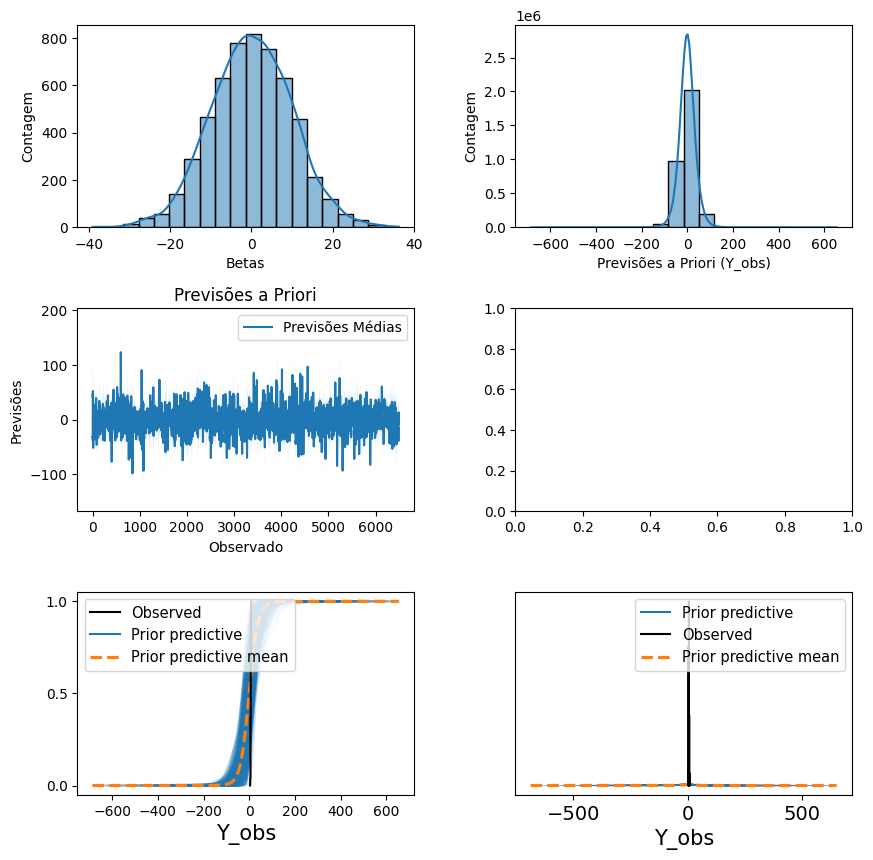

In [ ]:
analise_priori(ridge_trace_prior, y)


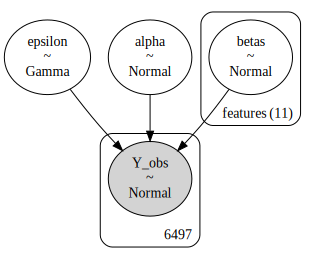

In [ ]:
pm.model_to_graphviz(model_ridge)

In [ ]:
def analise_posteriori(trace):
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  az.plot_ppc(trace, group='posterior', kind='cumulative', ax=axes[0]);
  az.plot_ppc(trace, group='posterior',ax=axes[1]);

  return fig, axes

Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


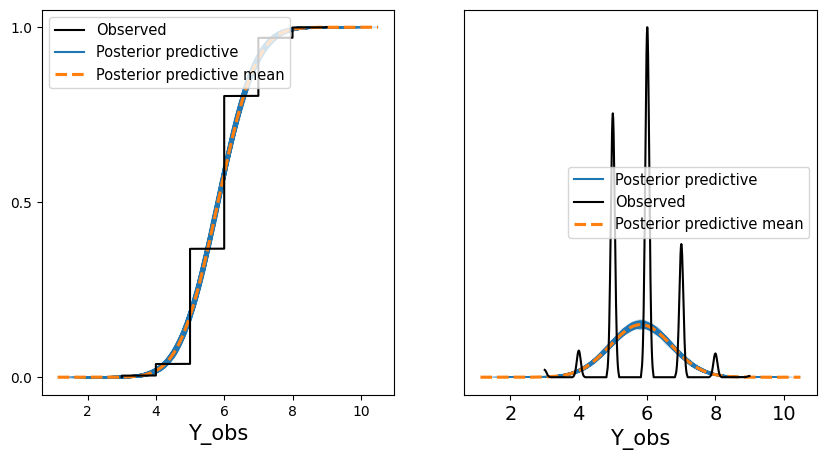

In [ ]:

with model_ridge:
  trace_pos_ridge = pm.sample_posterior_predictive(trace_ridge)

analise_posteriori(trace_pos_ridge)


LASSO

In [ ]:
import pymc as pm
import pytensor.tensor as pt  # Usar pytensor para a multiplicação de matrizes
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from math import sqrt

In [ ]:
# Criar o modelo Lasso Bayesiano
with pm.Model(coords=coords) as model_lasso:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Priori para os coeficientes de regressão (betas) com distribuição Laplace
    betas = pm.Laplace('betas', mu=0, b=1/sqrt(2), dims='features')  # b é o parâmetro de escala da Laplace

    # Priori para o desvio padrão do erro (epsilon)
    epsilon = pm.Gamma('epsilon', alpha=2, beta=1)

    # Definir a equação do modelo linear
    mu = alpha + pt.dot(X_scaled, betas)

    # Definir a verossimilhança (Normal)
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=y)

    # Amostrar da distribuição a priori
    lasso_trace_prior = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior
    trace_lasso = pm.sample(1000, tune=1000, target_accept=0.95)

# Exibir o resumo dos parâmetros ajustados

az.summary(trace_lasso)

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.818,0.009,5.802,5.837,0.000,0.000,1862.0,1325.0,1.00
betas[0],0.086,0.020,0.050,0.123,0.001,0.000,1012.0,1223.0,1.00
betas[1],-0.219,0.012,-0.242,-0.197,0.000,0.000,1370.0,1266.0,1.00
betas[2],-0.015,0.012,-0.036,0.008,0.000,0.000,1513.0,1391.0,1.00
betas[3],0.204,0.024,0.161,0.249,0.001,0.001,923.0,1121.0,1.00
betas[4],-0.017,0.011,-0.037,0.005,0.000,0.000,1876.0,1643.0,1.00
betas[5],0.106,0.014,0.079,0.131,0.000,0.000,1850.0,1502.0,1.00
betas[6],-0.140,0.016,-0.169,-0.110,0.000,0.000,1723.0,1384.0,1.00
betas[7],-0.161,0.036,-0.232,-0.098,0.001,0.001,849.0,998.0,1.00
betas[8],0.069,0.014,0.042,0.095,0.000,0.000,1220.0,1393.0,1.00


<ipython-input-32-4581fe9e5373>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Previsões a Priori (Y_obs)', ylabel='Contagem'>],
        [<Axes: title={'center': 'Previsões a Priori'}, xlabel='Observado', ylabel='Previsões'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


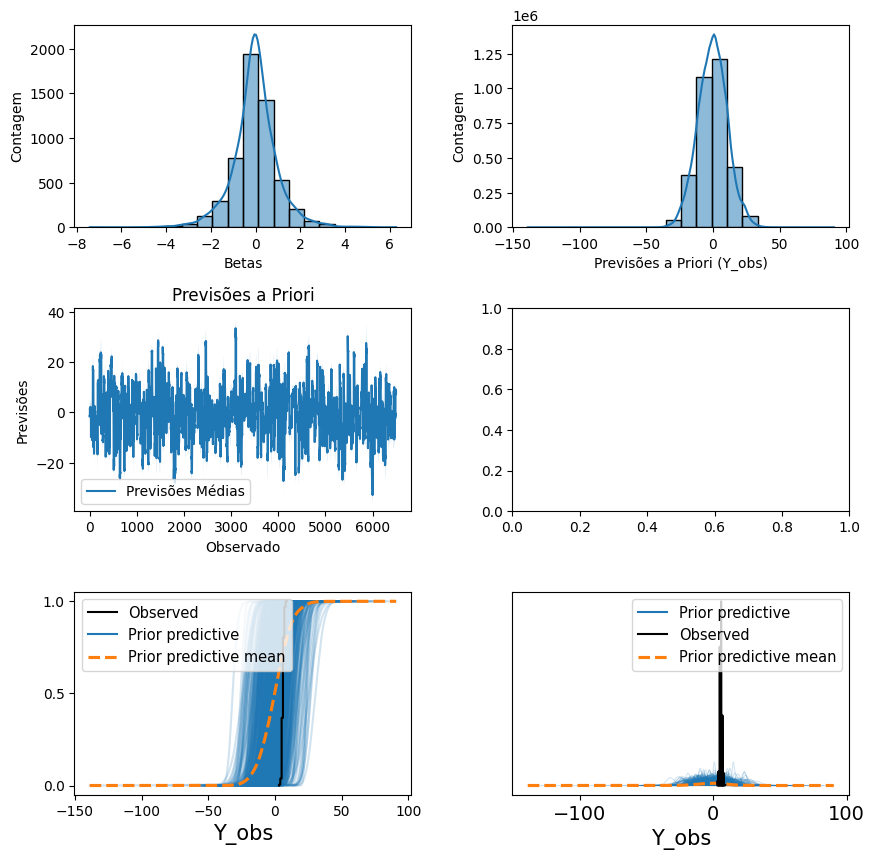

In [ ]:
# Supondo que 'y' é seu vetor de dados observados
analise_priori(lasso_trace_prior, y)

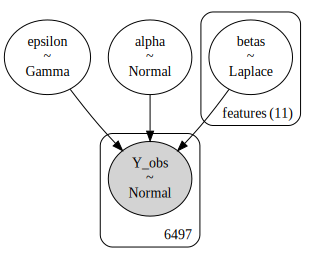

In [ ]:

pm.model_to_graphviz(model_lasso)

Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


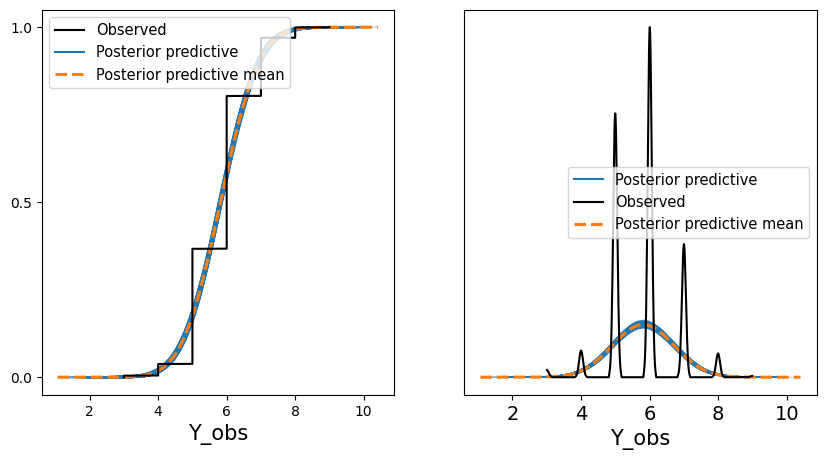

In [ ]:
with model_lasso:
  trace_pos_lasso = pm.sample_posterior_predictive(trace_lasso)

analise_posteriori(trace_pos_lasso)

HIERARQUICO

In [ ]:
# Criar o modelo Bayesiano Hierárquico
with pm.Model(coords=coords) as model_hierarchical:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Priori hiperparamétrica para o desvio padrão das Laplaces dos betas
    b_hyper = pm.Gamma('b_hyper', alpha=2, beta=1)

    # Priori hierárquica para os coeficientes de regressão (betas) com distribuição Laplace
    betas = pm.Laplace('betas', mu=0, b=b_hyper, dims='features')

    # Priori hiperparamétrica para o desvio padrão do erro (epsilon)
    epsilon_hyper = pm.Gamma('epsilon_hyper', alpha=2, beta=1)
    epsilon = pm.HalfNormal('epsilon', sigma=epsilon_hyper)

    # Definir a equação do modelo linear
    mu = alpha + pt.dot(X_scaled, betas)

    # Definir a verossimilhança (Normal)
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=y)

    # Amostrar da distribuição a priori
    trace_prior_hierarchical = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior
    trace_hierarchical = pm.sample(1000, tune=1000, target_accept=0.95)

    # Calcular log_likelihood
    pm.compute_log_likelihood(trace_hierarchical)

# Exibir o resumo dos parâmetros ajustados

az.summary(trace_hierarchical)


Output()

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.818,0.009,5.803,5.836,0.000,0.000,2014.0,1505.0,1.0
b_hyper,0.172,0.063,0.077,0.288,0.001,0.001,2346.0,1475.0,1.0
betas[0],0.079,0.020,0.041,0.117,0.001,0.000,1205.0,1439.0,1.0
betas[1],-0.219,0.012,-0.242,-0.197,0.000,0.000,1694.0,1502.0,1.0
betas[2],-0.015,0.011,-0.036,0.005,0.000,0.000,2241.0,1747.0,1.0
betas[3],0.196,0.026,0.149,0.246,0.001,0.001,1058.0,1249.0,1.0
betas[4],-0.018,0.011,-0.041,0.003,0.000,0.000,1797.0,1359.0,1.0
betas[5],0.104,0.014,0.080,0.131,0.000,0.000,1840.0,1222.0,1.0
betas[6],-0.137,0.016,-0.167,-0.108,0.000,0.000,1517.0,1314.0,1.0
betas[7],-0.149,0.038,-0.217,-0.076,0.001,0.001,948.0,1184.0,1.0


<ipython-input-32-4581fe9e5373>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Previsões a Priori (Y_obs)', ylabel='Contagem'>],
        [<Axes: title={'center': 'Previsões a Priori'}, xlabel='Observado', ylabel='Previsões'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


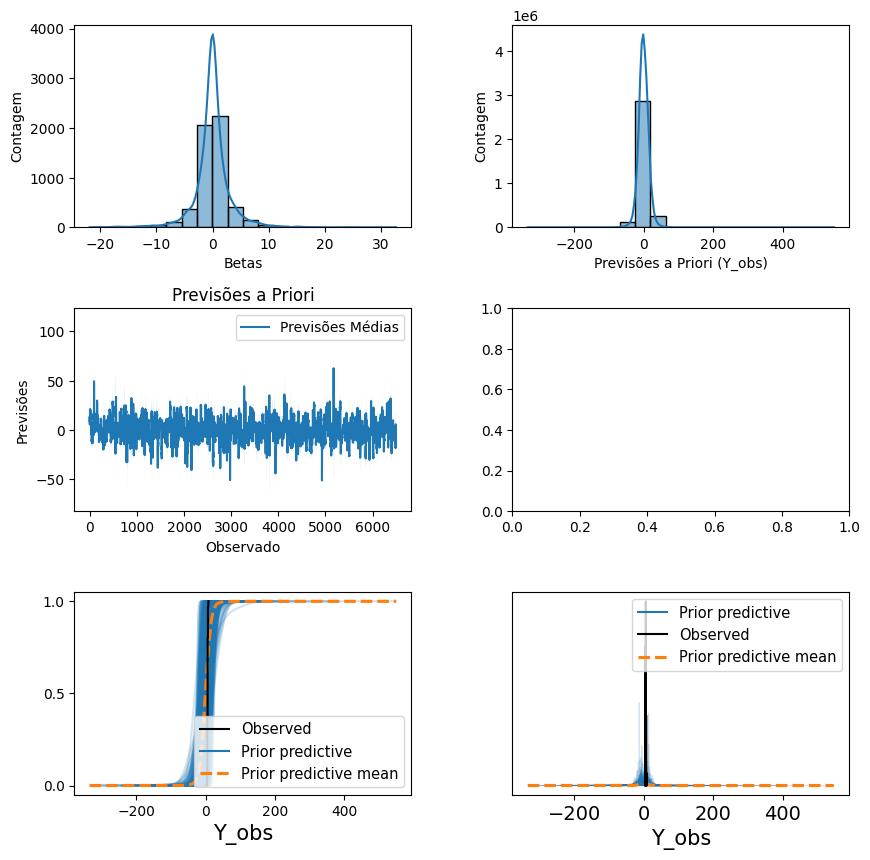

In [ ]:

analise_priori(trace_prior_hierarchical,y)

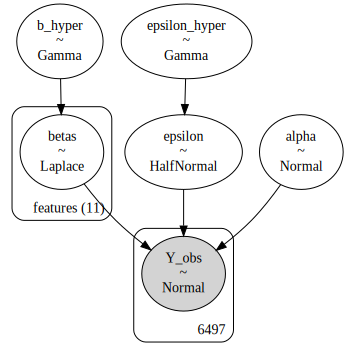

In [ ]:
pm.model_to_graphviz(model_hierarchical)

Output()

<Axes: xlabel='Y_obs'>

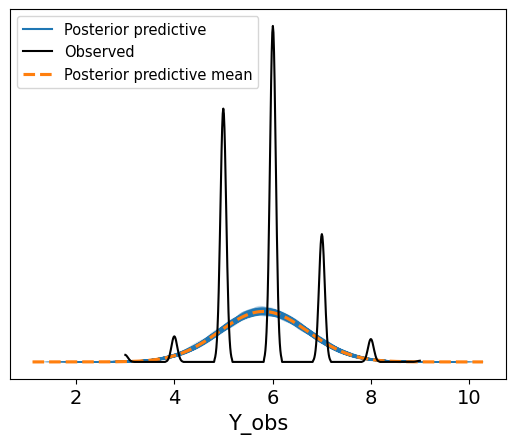

In [ ]:
with model_hierarchical:
  trace_pos_hierarc = pm.sample_posterior_predictive(trace_hierarchical)


# Agora, passe o posterior_predictive para a função de análise posterior
az.plot_ppc(posterior_predictive, data_pairs={"Y_obs": "Y_obs"})

ROBUSTO

In [ ]:
# Criar o modelo Bayesiano Robusto
with pm.Model(coords=coords) as model_robust:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', 0, 1)

    # Priori para os coeficientes de regressão (betas)
    betas = pm.Normal('betas', 0, 1, dims='features')

    # Priori para os graus de liberdade da distribuição Student-T (df)
    df = pm.Exponential('df', 1)

    # Definir a equação do modelo linear
    mu = alpha + pt.dot(X_scaled, betas)

    # Definir a verossimilhança com distribuição Student-T
    likelihood = pm.StudentT('Y_obs', nu=df, mu=mu, observed=y)

    # Amostrar da distribuição a priori
    robust_trace_prior = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior
    trace_robust = pm.sample(1000, tune=1000, target_accept=0.95)

# Exibir o resumo dos parâmetros ajustados

az.summary(trace_robust)

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.817,0.012,5.792,5.838,0.000,0.000,1855.0,1610.0,1.0
betas[0],0.091,0.029,0.036,0.144,0.001,0.001,802.0,1144.0,1.0
betas[1],-0.217,0.017,-0.251,-0.187,0.000,0.000,1482.0,1586.0,1.0
betas[2],-0.016,0.016,-0.046,0.015,0.000,0.000,1713.0,1416.0,1.0
betas[3],0.208,0.034,0.142,0.266,0.001,0.001,692.0,991.0,1.0
betas[4],-0.017,0.016,-0.046,0.013,0.000,0.000,1850.0,1366.0,1.0
betas[5],0.110,0.018,0.077,0.145,0.000,0.000,1835.0,1342.0,1.0
betas[6],-0.142,0.021,-0.181,-0.103,0.001,0.000,1632.0,1318.0,1.0
betas[7],-0.168,0.051,-0.258,-0.067,0.002,0.001,631.0,940.0,1.0
betas[8],0.072,0.020,0.034,0.109,0.001,0.000,870.0,1308.0,1.0


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:246: RuntimeWarning: divide by zero encountered in scalar divide
  t_j = np.power((c1 * (c2 / (N * f))), (2.0 / (3.0 + 2.0 * j)))
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:250: RuntimeWarning: divide by zero encountered in scalar power
  out = t - (2 * N * np.pi**0.5 * f) ** (-0.4)
<ipython-input-56-be4523a56207>:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


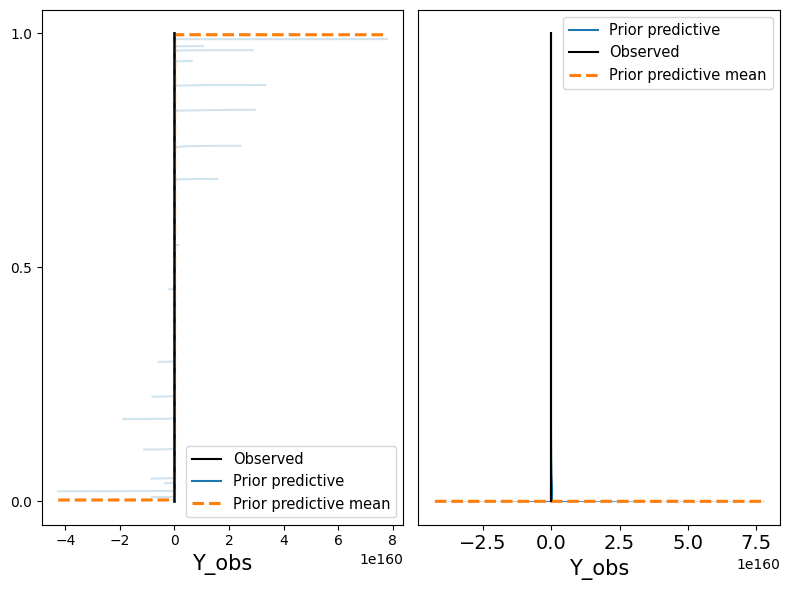

In [ ]:
# Criar subplots para exibir os gráficos
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# Plotar o Posterior Predictive Check cumulativo e regular
az.plot_ppc(robust_trace_prior, group='prior', kind='cumulative', ax=axes[0], observed=True)
az.plot_ppc(robust_trace_prior, group='prior', ax=axes[1], observed=True)

# Ajustar layout
plt.tight_layout()
plt.show()

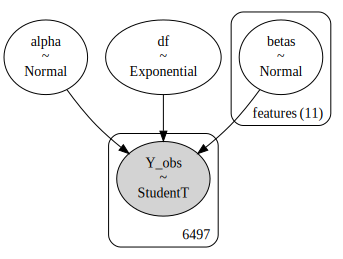

In [ ]:
pm.model_to_graphviz(model_robust)

Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


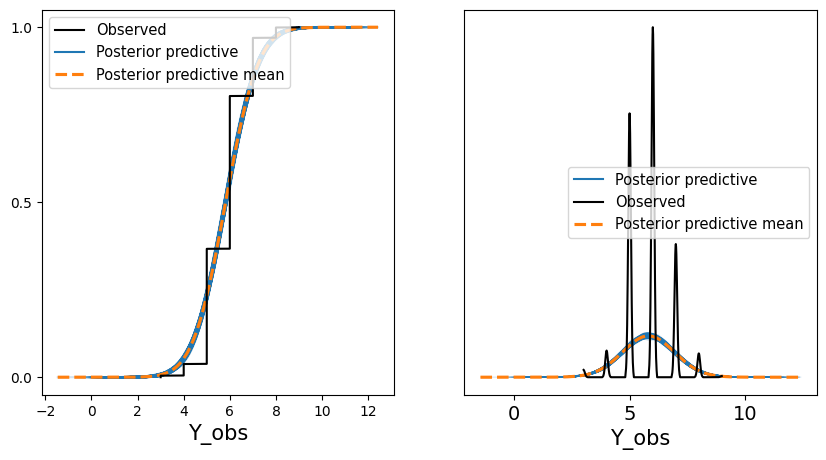

In [ ]:
with model_robust:
  trace_pos_robust = pm.sample_posterior_predictive(trace_robust)

analise_posteriori(trace_pos_robust)

COMPARANDO MODELOS

In [ ]:
# Verificar se o log_likelihood já existe antes de recalcular
if 'log_likelihood' not in trace_ridge.groups():
    with model_ridge:
        pm.compute_log_likelihood(trace_ridge)


if 'log_likelihood' not in trace_lasso.groups():
    with model_lasso:
        pm.compute_log_likelihood(trace_lasso)

if 'log_likelihood' not in trace_hierarquic.groups():
    with model_hierarchical:
        pm.compute_log_likelihood(trace_robust)

if 'log_likelihood' not in trace_robust.groups():
    with model_robust:
        pm.compute_log_likelihood(trace_robust)

Output()

Output()

In [ ]:
# Verifique se o log_likelihood foi corretamente adicionado
print(trace_ridge.groups())

print(trace_lasso.groups())

print(trace_robust.groups())

print(trace_hierarchical.groups())

['posterior', 'sample_stats', 'observed_data']
['posterior', 'sample_stats', 'observed_data']
['posterior', 'sample_stats', 'observed_data']
['posterior', 'sample_stats', 'observed_data']


In [ ]:
# Amostragem para o modelo Lasso
with model_lasso:
    trace_lasso = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)
    # Incluindo o cálculo do log likelihood
    trace_lasso = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Amostragem para o modelo Hierárquico
with model_hierarchical:
    trace_hierarchical = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Amostragem para o modelo Robusto
with model_robust:
    trace_robust = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Amostragem para o modelo Ridge
with model_ridge:
    trace_ridge = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()